In [1]:
import arviz as az
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm3
import pymc4 as pm4
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pm3.set_tt_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

az.style.use('arviz-darkgrid')
dtype = tf.float32
tfb = tfp.bijectors
tfd = tfp.distributions

In [3]:
MU = 12
SIGMA = 2.2
data = np.random.normal(MU, SIGMA, 200)

@pm4.model
def model():
    mu = yield pm4.Normal('mu', 0, 10)
    sigma = yield pm4.Exponential('sigma', 1)
    ll = yield pm4.Normal('ll', mu, sigma, observed=data)

In [4]:
state, deterministic_names = pm4.inference.utils.initialize_sampling_state(model())
unobserved_keys = state.all_unobserved_values.keys()

In [5]:
@tf.function(autograph=False)
def deterministics_callback(*values, **kwargs):
    if kwargs and values:
        raise TypeError("Either list state should be passed or a dict one")
    elif values:
        kwargs = dict(zip(unobserved_keys, values))
    st = pm4.flow.SamplingState.from_values(kwargs, observed_values=state.observed_values)
    _, st = pm4.flow.evaluate_model_transformed(model(), state=st)
    for transformed_name in st.transformed_values:
        untransformed_name = pm4.utils.NameParts.from_name(transformed_name).full_untransformed_name
        st.deterministics[untransformed_name] = st.untransformed_values.pop(untransformed_name)
    return st.deterministics.values()

In [6]:
# Tracking all transformed + untransformed + deterministics_values - 
def trace_fn(traceable_quantities):
        return dict(
            loss=traceable_quantities.loss,
            **dict(zip(unobserved_keys, traceable_quantities.parameters[::2])),
            **dict(
                zip(
                    deterministic_names,
                    deterministics_callback(*traceable_quantities.parameters[::2]),
                )
            )
        )    

In [7]:
mean_field = pm4.fit(model(), num_steps=30000, trace_fn=trace_fn)

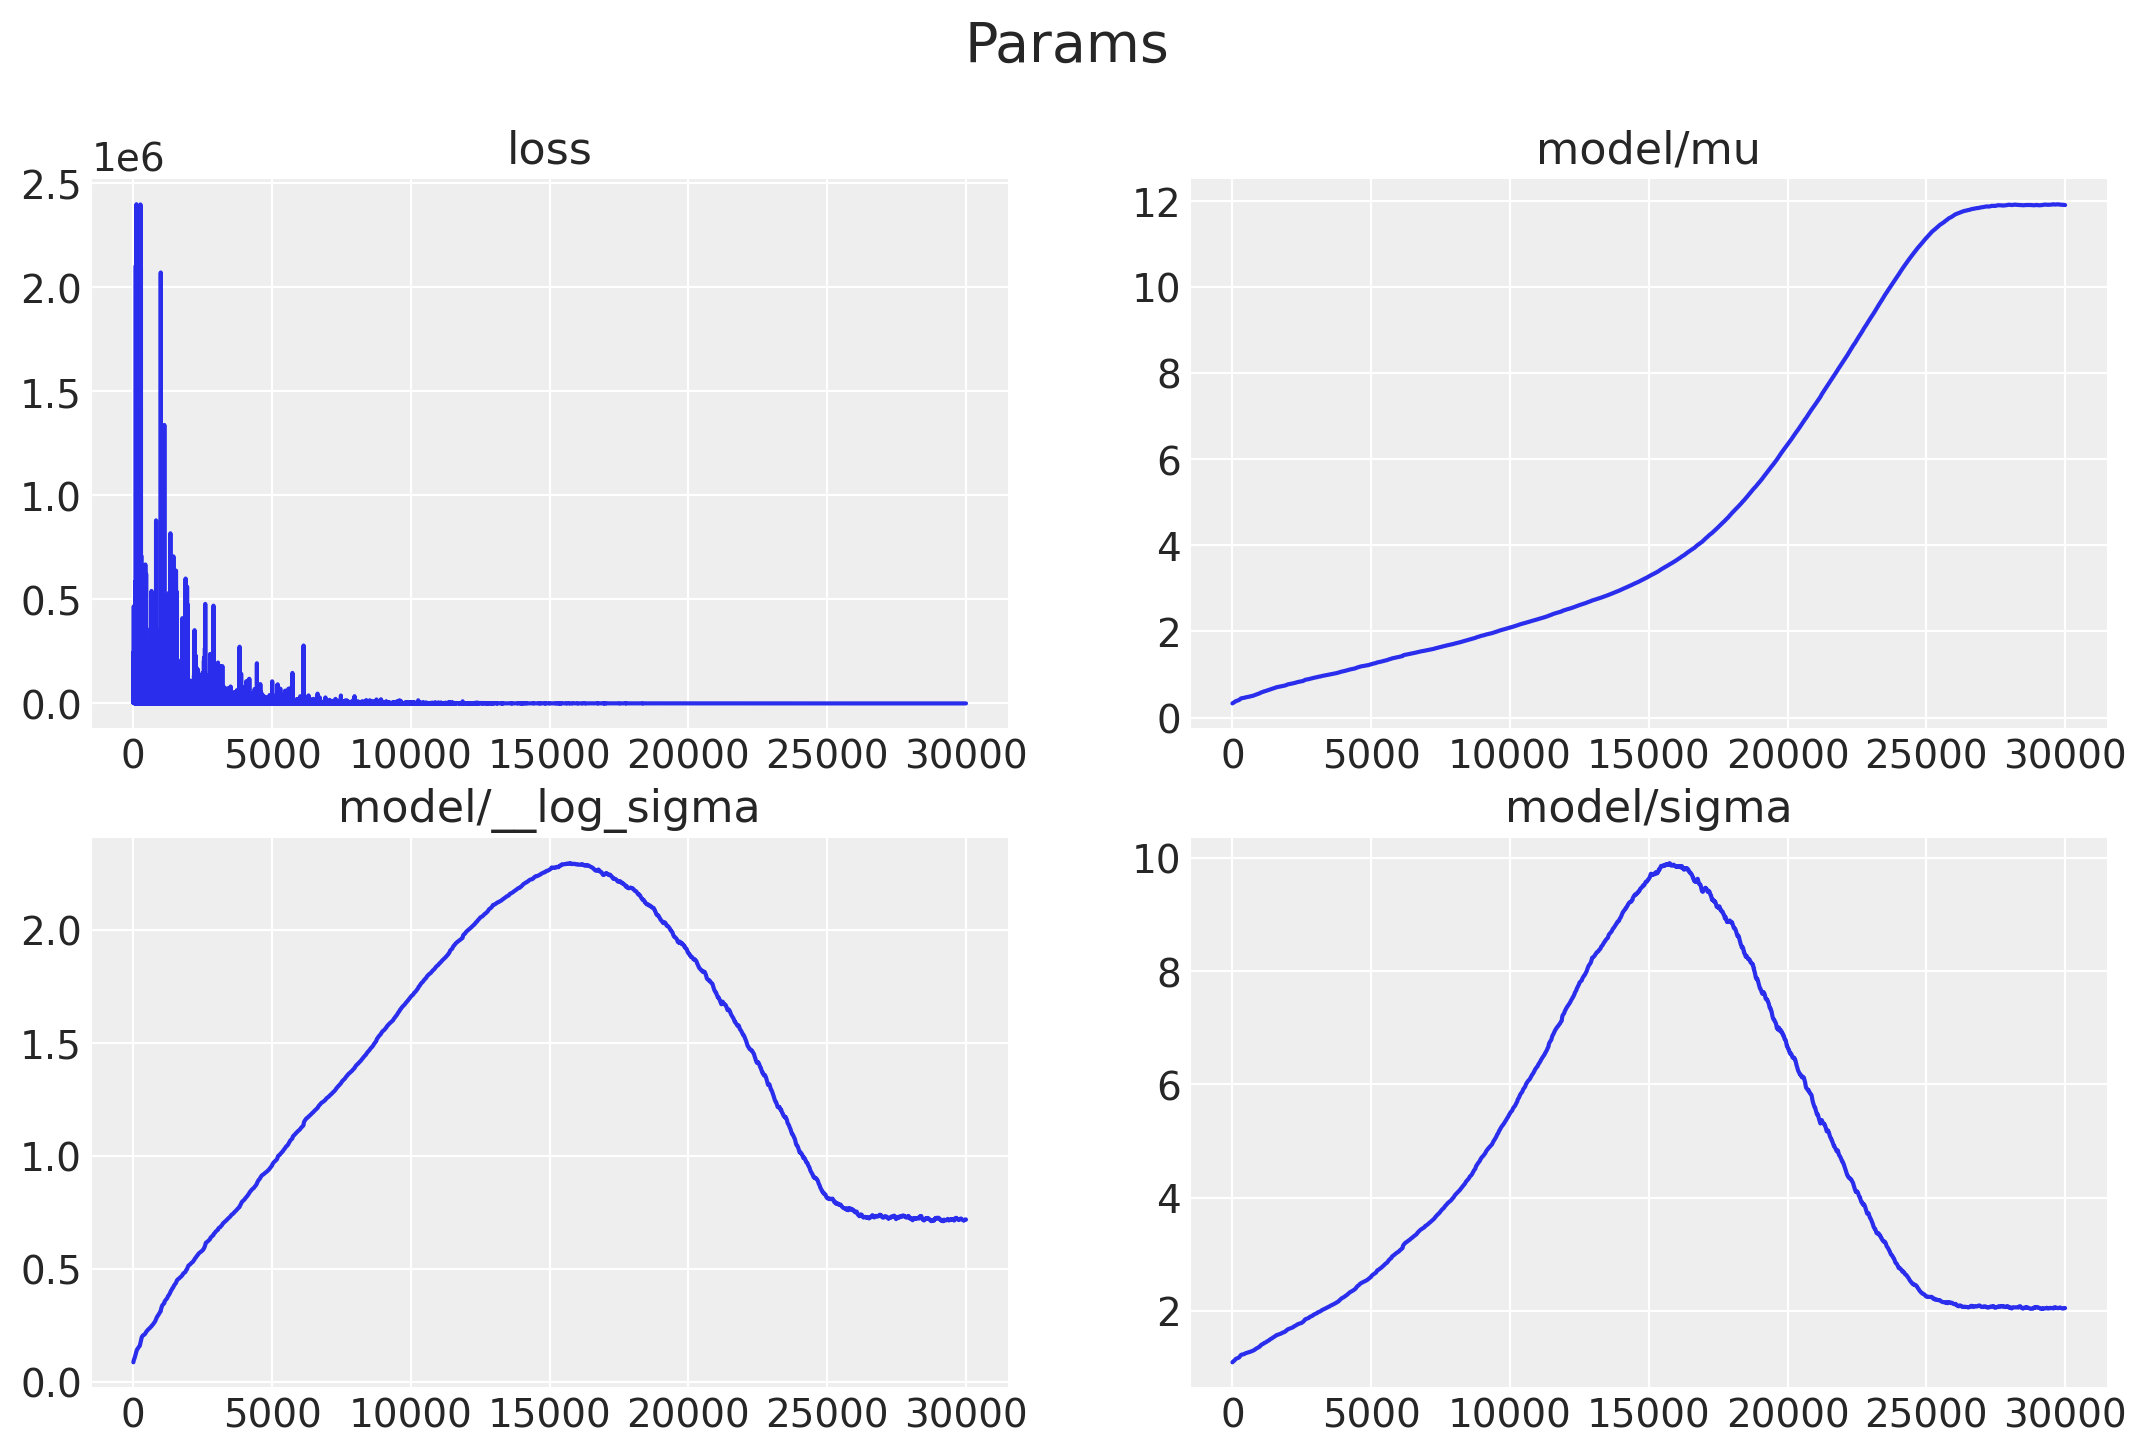

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
fig.suptitle('Params', fontsize=20)
for param, ax in zip(mean_field.losses.keys(), axes.ravel()):
    ax.plot(mean_field.losses[param])
    ax.set_title(param)